In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/10-716/adversarial-hard-negatives-2022-adversarial/image

/content/drive/.shortcut-targets-by-id/1VNVUBHcfBzcVUrxUeOOkpf5wPwp7ERLW/10-716/adversarial-hard-negatives-2022-adversarial/image


In [3]:
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle

from model import *
from main import *

import utils

import os
import numpy as np
import itertools

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Home device: {}'.format(device))

from matplotlib import pyplot as plt

Home device: cuda:0
Home device: cuda:0
Home device: cuda:0


In [4]:
def load_model(name):
  model_path = f'./modelscopy/{name}'
  model = Model().to(device)
  model = nn.DataParallel(model)
  model.load_state_dict(torch.load(model_path, map_location='cuda:0'))
  model.eval()
  return model

In [5]:
def make_adv(model, x, tau_plus, beta, batch_size):
    eps = 0.03
    x.detach()
    inputs1_adv = torch.autograd.Variable(x, requires_grad=True).to(device)

    # adversarial mode with separate batch norm steps?
    feat1, out1 = model(x)
    feat2, out2 = model(inputs1_adv)

    tmp_loss = criterion(out1, out2, None, None, tau_plus,
                         batch_size, beta, 'hard', epoch=10, temp=.5)
    tmp_loss.backward()
    inputs1_adv.data = inputs1_adv.data + \
        (eps * torch.sign(inputs1_adv.grad.data))
    inputs1_adv.grad.data.zero_()
    inputs1_adv.detach()
    return inputs1_adv

In [6]:
def visualize_plots(model,method,batch_size,tau_plus=None,beta=None,dataset_name = 'mnist'):


  if method == 'adv' or method == 'easy':
    tau_plus = 0
    beta = 0

  if method == 'adv':

    train_data, _, test_data = utils.get_dataset(dataset_name, root='../data/', pair=True)
    test_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)
    
    coords1 = []
    coords2 = []
    labels = []
    Ngs = []
    Pos = []

    data_loader = test_loader

    for _ in range(1):
      for data1, data2, target in tqdm(data_loader):

          if data1.shape[0]!=batch_size:
            break

          data1 = data1.to(device, non_blocking=True)
          data2 = make_adv(model, data1,tau_plus,beta,batch_size)

          with torch.no_grad():
            
              target = target.to(device,non_blocking=True)

              _, out1 = model(data1)
              _, out2 = model(data2)

              labels.append(target.cpu().numpy())
              normalized_output1 = out1.cpu().detach().numpy() / np.linalg.norm(out1.cpu().detach().numpy(), axis=1, keepdims=True)
              normalized_output2 = out2.cpu().detach().numpy() / np.linalg.norm(out2.cpu().detach().numpy(), axis=1, keepdims=True)

              coords1.append(normalized_output1)
              coords2.append(normalized_output2)
              _, ng,pos = criterion(out1, out2, target, target, tau_plus, batch_size, beta, 'hard', epoch=10, temp=.5, return_Ng=True)
              Ngs.append(ng)
              Pos.append(pos)

  if method == 'hard' or method == 'easy':

    train_data, _, test_data = utils.get_dataset(dataset_name, root='../data/', pair=True)
    test_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)
    
    coords1 = []
    coords2 = []
    labels = []
    Ngs = []
    Pos = []

    data_loader = test_loader
    
    for _ in range(1):
      for data1, data2, target in tqdm(data_loader):

          if data1.shape[0]!=batch_size:
            break

          data1 = data1.to(device, non_blocking=True)
          data2 = data2.to(device, non_blocking=True)

          with torch.no_grad():
            
              target = target.to(device,non_blocking=True)

              _, out1 = model(data1)
              _, out2 = model(data2)

              labels.append(target.cpu().numpy())
              normalized_output1 = out1.cpu().detach().numpy() / np.linalg.norm(out1.cpu().detach().numpy(), axis=1, keepdims=True)
              normalized_output2 = out2.cpu().detach().numpy() / np.linalg.norm(out2.cpu().detach().numpy(), axis=1, keepdims=True)

              coords1.append(normalized_output1)
              coords2.append(normalized_output2)
              _, ng,pos = criterion(out1, out2, target, target, tau_plus, batch_size, beta, method, epoch=10, temp=.5, return_Ng=True)
              Ngs.append(ng)
              Pos.append(pos)

  Ngs = torch.cat(Ngs).detach().cpu().numpy()
  Pos = torch.cat(Pos).detach().cpu().numpy()

  out = Pos/(Pos+Ngs)

  # out = out/sum(out)

  # plt.hist(out, weights = np.ones(len(out))/len(out))
  # plt.xlim(0,1)
  # plt.show()

  return out

In [7]:
results_all = {}

In [8]:
for model_name in os.listdir('modelscopy'):
  
  split_name = model_name.split('_')
  epoch = split_name[-1].split('.')[0]

  if epoch == '1' or epoch == '5' or epoch == '9':

    batch_size = split_name[-4]
    tau = split_name[-3]
    beta = split_name[-2]
    name = split_name[1:-4]
    name = ' '.join(name)

    model_details = f'name = {name}, tau = {tau}, beta = {beta}, epoch = {epoch}'
    print(model_details)

    model = load_model(model_name)

    out = visualize_plots(model,'hard',64,tau_plus=0.5,beta = 30)
    results_all[(f'model_training:{model_details}',f'eval dist:hard,tau=0.5,beta = 30')] = out

    out = visualize_plots(model,'easy',64)
    results_all[(f'model_training:{model_details}',f'eval dist:easy,tau=0.0,beta = 0')] = out

    out = visualize_plots(model,'adv',64)
    results_all[(f'model_training:{model_details}',f'eval dist:adv,tau=0.0,beta = 0')] = out

name = hard model, tau = 0.0, beta = 0.0, epoch = 1


 99%|█████████▉| 197/198 [00:23<00:00,  8.47it/s]


name = hard model, tau = 0.0, beta = 0.0, epoch = 5


 99%|█████████▉| 197/198 [00:23<00:00,  8.48it/s]


name = hard model, tau = 0.0, beta = 0.0, epoch = 9


 99%|█████████▉| 197/198 [00:23<00:00,  8.47it/s]


name = hard adv model, tau = 0.0, beta = 0.0, epoch = 1


 99%|█████████▉| 197/198 [00:23<00:00,  8.48it/s]


name = hard adv model, tau = 0.0, beta = 0.0, epoch = 5


 99%|█████████▉| 197/198 [00:23<00:00,  8.48it/s]


name = hard adv model, tau = 0.0, beta = 0.0, epoch = 9


 99%|█████████▉| 197/198 [00:23<00:00,  8.45it/s]


name = hard model, tau = 0.5, beta = 1.0, epoch = 1


 99%|█████████▉| 197/198 [00:23<00:00,  8.41it/s]


name = hard model, tau = 0.5, beta = 1.0, epoch = 5


 99%|█████████▉| 197/198 [00:23<00:00,  8.41it/s]


name = hard model, tau = 0.5, beta = 1.0, epoch = 9


 99%|█████████▉| 197/198 [00:23<00:00,  8.42it/s]


name = hard model, tau = 0.5, beta = 30.0, epoch = 1


 99%|█████████▉| 197/198 [00:23<00:00,  8.41it/s]


name = hard model, tau = 0.5, beta = 30.0, epoch = 5


 99%|█████████▉| 197/198 [00:23<00:00,  8.41it/s]


name = hard model, tau = 0.5, beta = 30.0, epoch = 9


 99%|█████████▉| 197/198 [00:23<00:00,  8.41it/s]


name = 0.5 model kalantidis, tau = 0.5, beta = 30.0, epoch = 1


 99%|█████████▉| 197/198 [00:23<00:00,  8.41it/s]


name = 0.5 model kalantidis, tau = 0.5, beta = 30.0, epoch = 5


 99%|█████████▉| 197/198 [00:23<00:00,  8.40it/s]


name = 0.5 model kalantidis, tau = 0.5, beta = 30.0, epoch = 9


 99%|█████████▉| 197/198 [00:23<00:00,  8.41it/s]


name = 0.5 model kalantidis, tau = 0.5, beta = 1.0, epoch = 1


 99%|█████████▉| 197/198 [00:23<00:00,  8.41it/s]


name = 0.5 model kalantidis, tau = 0.5, beta = 1.0, epoch = 5


 99%|█████████▉| 197/198 [00:23<00:00,  8.41it/s]


name = 0.5 model kalantidis, tau = 0.5, beta = 1.0, epoch = 9


 99%|█████████▉| 197/198 [00:23<00:00,  8.40it/s]


name = 0.5 model kalantidis, tau = 0.5, beta = 0.0, epoch = 1


 99%|█████████▉| 197/198 [00:23<00:00,  8.40it/s]


name = 0.5 model kalantidis, tau = 0.5, beta = 0.0, epoch = 5


 99%|█████████▉| 197/198 [00:23<00:00,  8.40it/s]


name = 0.5 model kalantidis, tau = 0.5, beta = 0.0, epoch = 9


 99%|█████████▉| 197/198 [00:23<00:00,  8.41it/s]


In [9]:
with open("results_consolidated.pkl","wb") as f:
  pickle.dump(results_all,f)

In [ ]:
# # batch_size,tau_plus,epoch = 256,0,10
# beta=0
# eps = .03
# dataset_name = 'mnist'

In [ ]:
torch.manual_seed(42)
# batch_size = 32
# train_data, _, test_data = utils.get_dataset(dataset_name, root='../data/', pair=True)
# test_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)

In [ ]:
%%capture
model_path = f'./modelscopy/mnist_hard_model_64_0.0_0.0_10.pth'
model = Model().to(device)
model = nn.DataParallel(model)
model.load_state_dict(torch.load(model_path, map_location='cuda:0'))
model.eval()

./modelscopy/mnist_hard_model_64_0.0_0.0_1.pth
64


 99%|█████████▉| 197/198 [00:23<00:00,  8.37it/s]


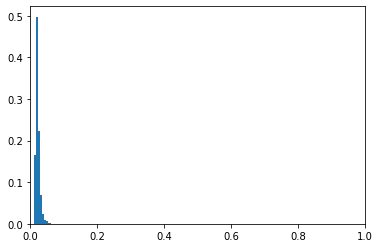

./modelscopy/mnist_hard_model_64_0.0_0.0_5.pth
64


 99%|█████████▉| 197/198 [00:23<00:00,  8.38it/s]


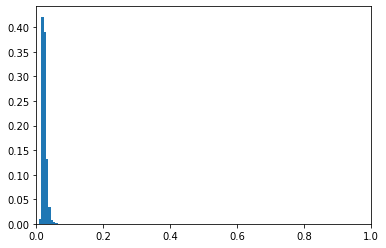

./modelscopy/mnist_hard_model_64_0.0_0.0_9.pth
64


 99%|█████████▉| 197/198 [00:23<00:00,  8.39it/s]


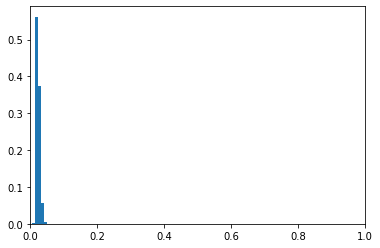

In [22]:
for epoch in range(1,11,4):
  
  print(f'./modelscopy/mnist_hard_model_64_0.0_0.0_{epoch}.pth')

  model_path = f'./modelscopy/mnist_hard_model_64_0.0_0.0_{epoch}.pth'
  model = Model().to(device)
  model = nn.DataParallel(model)
  model.load_state_dict(torch.load(model_path, map_location='cuda:0'))
  model.eval()

  out = visualize_plots(model,'adv',64)
  results[f'{epoch},adv,hard_model_0.0_0'] = out

./modelscopy/mnist_hard_model_64_0.0_0.0_1.pth


 99%|█████████▉| 197/198 [00:08<00:00, 23.04it/s]


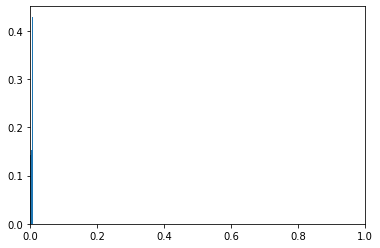

./modelscopy/mnist_hard_model_64_0.0_0.0_5.pth


 99%|█████████▉| 197/198 [00:08<00:00, 23.49it/s]


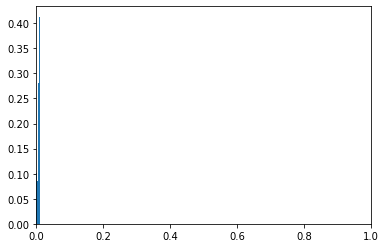

./modelscopy/mnist_hard_model_64_0.0_0.0_9.pth


 99%|█████████▉| 197/198 [00:08<00:00, 23.42it/s]


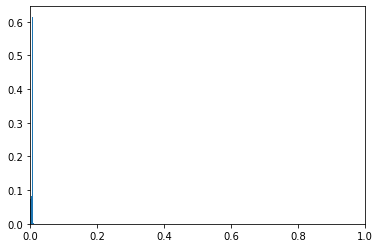

In [23]:
# for epoch in range(1,11,4):
#   print(f'./modelscopy/mnist_hard_adv_model_64_0.0_0.0_{epoch}.pth')

#   model_path = f'./modelscopy/mnist_hard_adv_model_64_0.0_0.0_{epoch}.pth'
#   model = Model().to(device)
#   model = nn.DataParallel(model)
#   model.load_state_dict(torch.load(model_path, map_location='cuda:0'))
#   model.eval()

#   out = visualize_plots(model,'hard', 64, tau_plus = 0.5, beta = 30)
#   results[f'{epoch},hard,0.5,30,hard_adv_model_0.0_0.0'] = out

for epoch in range(1,11,4):
  
  print(f'./modelscopy/mnist_hard_model_64_0.0_0.0_{epoch}.pth')

  model_path = f'./modelscopy/mnist_hard_model_64_0.0_0.0_{epoch}.pth'
  model = Model().to(device)
  model = nn.DataParallel(model)
  model.load_state_dict(torch.load(model_path, map_location='cuda:0'))
  model.eval()

  out = visualize_plots(model,'hard',64,tau_plus=0.5,beta = 30)
  results[f'{epoch},hard,0.5,30,hard_model_0.0_0'] = out

In [ ]:
li

./modelscopy/mnist_hard_model_64_0.0_0.0_1.pth


 99%|█████████▉| 197/198 [00:08<00:00, 23.64it/s]


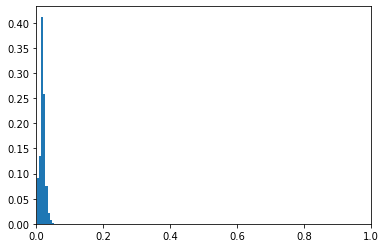

./modelscopy/mnist_hard_model_64_0.0_0.0_5.pth


 99%|█████████▉| 197/198 [00:08<00:00, 23.21it/s]


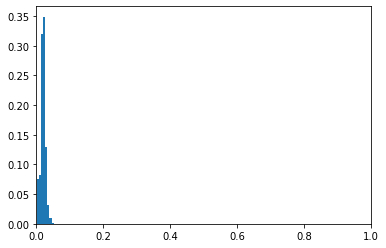

./modelscopy/mnist_hard_model_64_0.0_0.0_9.pth


 99%|█████████▉| 197/198 [00:08<00:00, 23.00it/s]


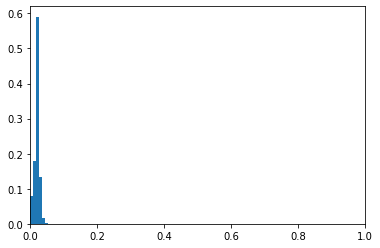

In [24]:
# for epoch in range(1,11,4):
#   print(f'./modelscopy/mnist_hard_adv_model_64_0.0_0.0_{epoch}.pth')

#   model_path = f'./modelscopy/mnist_hard_adv_model_64_0.0_0.0_{epoch}.pth'
#   model = Model().to(device)
#   model = nn.DataParallel(model)
#   model.load_state_dict(torch.load(model_path, map_location='cuda:0'))
#   model.eval()
  
#   out = visualize_plots(model,'easy',64)
#   results[f'{epoch},easy,hard_adv_model_0.0_0.0'] = out

for epoch in range(1,11,4):
  
  print(f'./modelscopy/mnist_hard_model_64_0.0_0.0_{epoch}.pth')

  model_path = f'./modelscopy/mnist_hard_model_64_0.0_0.0_{epoch}.pth'
  model = Model().to(device)
  model = nn.DataParallel(model)
  model.load_state_dict(torch.load(model_path, map_location='cuda:0'))
  model.eval()

  out = visualize_plots(model,'easy',64)
  results[f'{epoch},easy,hard_model_0.0_0'] = out

mnist_hard_model_64_0.0_0.0_10.pth
64


 99%|█████████▉| 197/198 [00:23<00:00,  8.33it/s]


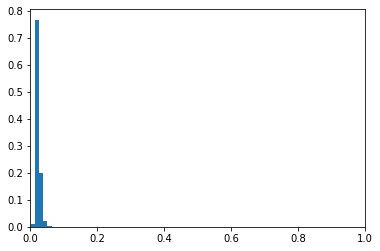

 99%|█████████▉| 197/198 [00:09<00:00, 20.38it/s]


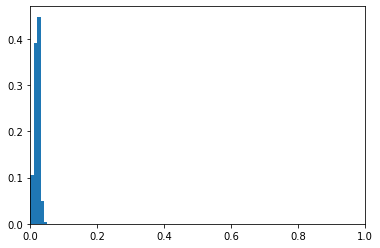

 99%|█████████▉| 197/198 [00:09<00:00, 21.32it/s]


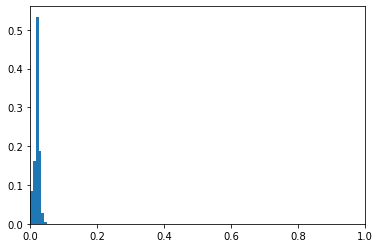

mnist_hard_adv_model_64_0.0_0.0_10.pth
64


 99%|█████████▉| 197/198 [00:23<00:00,  8.31it/s]


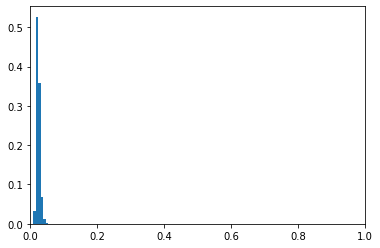

 99%|█████████▉| 197/198 [00:08<00:00, 23.05it/s]


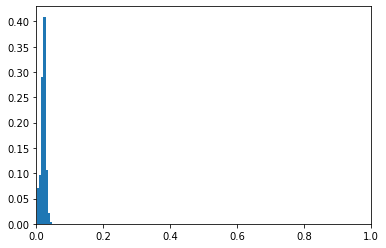

 99%|█████████▉| 197/198 [00:08<00:00, 22.67it/s]


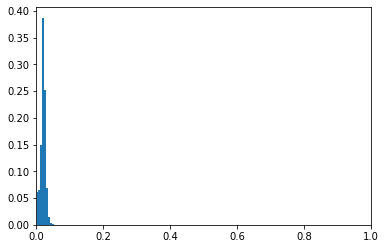

mnist_hard_model_64_0.5_1.0_10.pth
64


 99%|█████████▉| 197/198 [00:23<00:00,  8.33it/s]


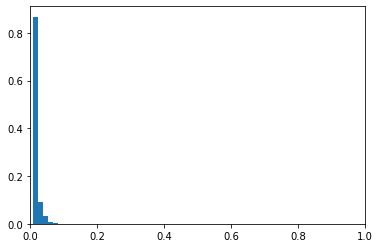

 99%|█████████▉| 197/198 [00:08<00:00, 21.90it/s]


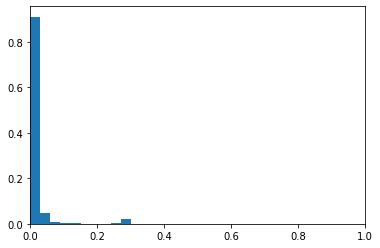

 99%|█████████▉| 197/198 [00:08<00:00, 22.80it/s]


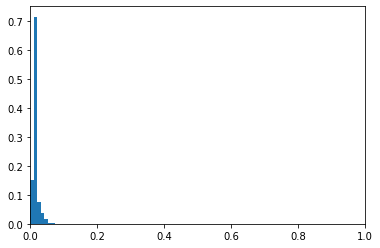

mnist_hard_model_64_0.5_30.0_10.pth
64


 99%|█████████▉| 197/198 [00:23<00:00,  8.30it/s]


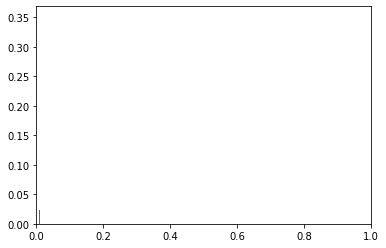

 99%|█████████▉| 197/198 [00:09<00:00, 20.28it/s]


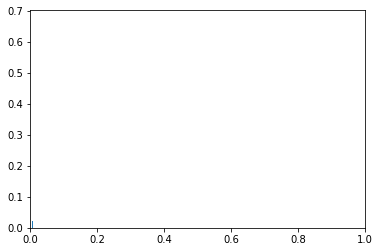

 99%|█████████▉| 197/198 [00:09<00:00, 21.39it/s]


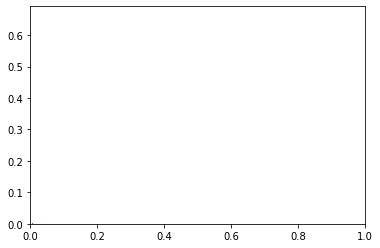

mnist_0.5_model_kalantidis_64_0.5_30.0_10.pth
64


 99%|█████████▉| 197/198 [00:23<00:00,  8.31it/s]


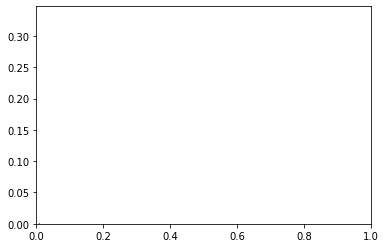

 99%|█████████▉| 197/198 [00:08<00:00, 22.47it/s]


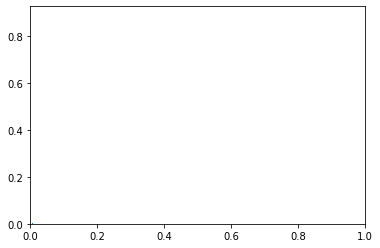

 99%|█████████▉| 197/198 [00:08<00:00, 22.64it/s]


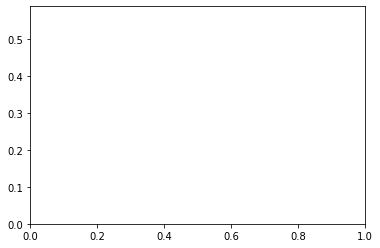

mnist_0.5_model_kalantidis_64_0.5_1.0_10.pth
64


 99%|█████████▉| 197/198 [00:23<00:00,  8.33it/s]


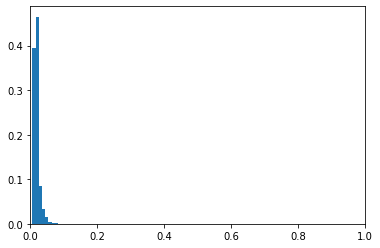

 99%|█████████▉| 197/198 [00:08<00:00, 22.56it/s]


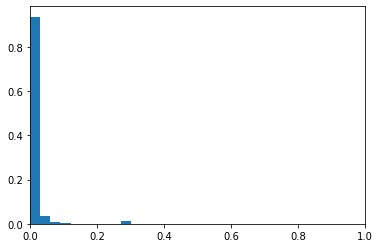

 99%|█████████▉| 197/198 [00:08<00:00, 22.52it/s]


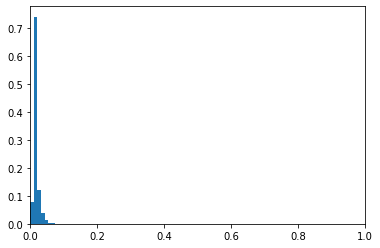

mnist_0.5_model_kalantidis_64_0.5_0.0_10.pth
64


 99%|█████████▉| 197/198 [00:23<00:00,  8.34it/s]


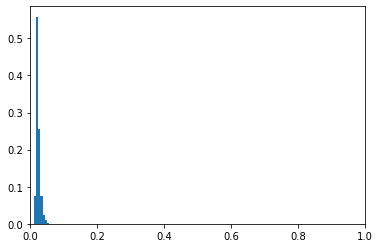

 99%|█████████▉| 197/198 [00:08<00:00, 23.15it/s]


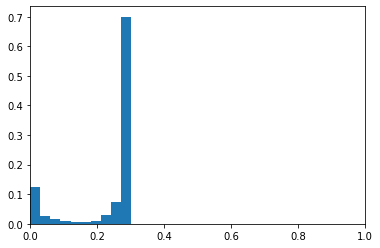

 99%|█████████▉| 197/198 [00:08<00:00, 23.01it/s]


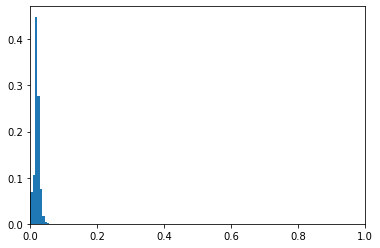

In [ ]:
for model_name in os.listdir('modelscopy'):
  if model_name[-6:-4] == '10':
    model_path = f'./modelscopy/{model_name}'
    model = Model().to(device)
    model = nn.DataParallel(model)
    model.load_state_dict(torch.load(model_path, map_location='cuda:0'))
    model.eval()

    bs,tau,beta,epoch = model_name.split('_')[-4:]
    epoch = epoch.split('.')[0]
    
    print(model_name)

    out = visualize_plots(model,'adv',int(bs))
    results[f'{10},adv,{model_name}'] = out
    out = visualize_plots(model,'hard',int(bs), tau_plus = float(tau), beta = float(beta))
    results[f'{10},hard,{tau},{beta},{model_name}'] = out
    out = visualize_plots(model,'easy',int(bs))
    results[f'{10},easy,{model_name}'] = out

(0.0, 1.0)

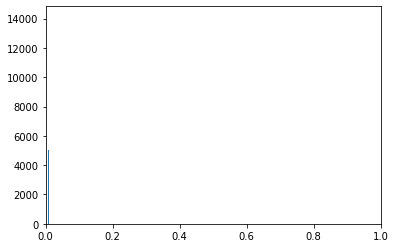

In [ ]:
plt.hist(results['10,easy,mnist_0.5_model_kalantidis_64_0.5_30.0_10.pth'])
plt.xlim(0,1)

64


 99%|█████████▉| 197/198 [00:32<00:00,  6.12it/s]


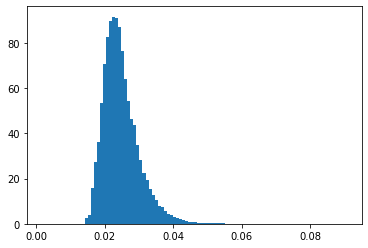

array([274.57196, 226.98642, 320.1507 , ..., 241.62418, 278.93103,
       231.1698 ], dtype=float32)

In [ ]:
visualize_plots(model,'adv',64)

 99%|█████████▉| 197/198 [00:10<00:00, 19.25it/s]


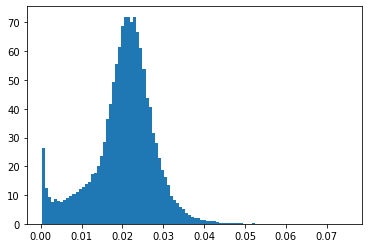

array([249.96736, 267.56348, 318.02948, ..., 272.13272, 326.53137,
       275.46576], dtype=float32)

In [ ]:
visualize_plots(model,'hard',64, tau_plus = 0, beta = 0.0)

 99%|█████████▉| 197/198 [00:10<00:00, 19.51it/s]


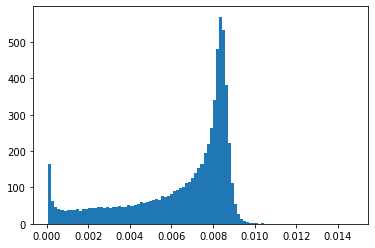

array([1233.3438 ,  871.56287, 1008.9769 , ..., 1445.5767 ,  879.5588 ,
        851.8362 ], dtype=float32)

In [ ]:
visualize_plots(model,'hard',64, tau_plus = 0.5, beta = 10)

 99%|█████████▉| 197/198 [00:10<00:00, 19.44it/s]


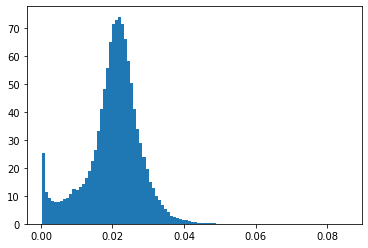

array([298.67395, 258.12   , 288.26053, ..., 354.34903, 292.8662 ,
       257.12735], dtype=float32)

In [ ]:
visualize_plots(model,'easy',64)

In [ ]:
%%capture
model_path = f'./10-716 Models/mnist_hard_model_64_0.0_0.0_10.pth'
model = Model().to(device)
model = nn.DataParallel(model)
model.load_state_dict(torch.load(model_path, map_location='cuda:0'))
model.eval()

64


 99%|█████████▉| 197/198 [01:28<00:00,  2.23it/s]


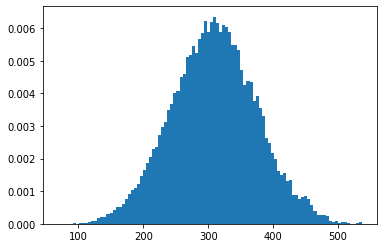

array([239.94005, 355.38687, 316.37912, ..., 243.25229, 376.60413,
       248.94601], dtype=float32)

In [ ]:
visualize_plots(model,'adv',64)

 99%|█████████▉| 197/198 [00:20<00:00,  9.41it/s]


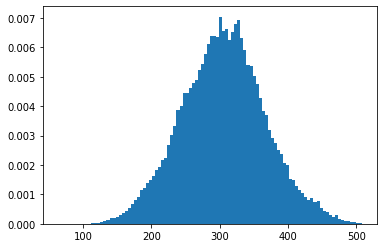

array([255.2528 , 270.22552, 336.94888, ..., 271.30316, 329.4577 ,
       270.5266 ], dtype=float32)

In [ ]:
visualize_plots(model,'hard',64, tau_plus = 0, beta = 0.0)

 99%|█████████▉| 197/198 [00:20<00:00,  9.42it/s]


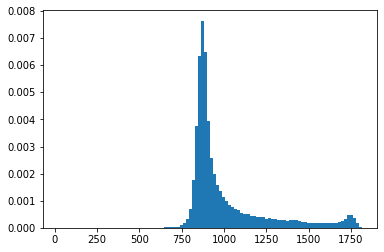

array([1082.4905 ,  894.6808 ,  920.51276, ..., 1059.416  ,  956.3551 ,
       1749.3453 ], dtype=float32)

In [ ]:
visualize_plots(model,'hard',64, tau_plus = 0.5, beta = 10)

In [ ]:
visualize_plots(model,'easy',64)

 31%|███▏      | 62/198 [00:06<00:13,  9.98it/s]

In [26]:
import pickle

In [27]:
with open("results.pkl","wb") as f:
  pickle.dump(results,f)